In [1]:
# load some libraries
import sys
import os
import pickle
import gzip
sys.path.insert(1, '..')
os.chdir('..')

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import darts
from darts import metrics

from lib.gluformer.model import *
from lib.latent_ode.trainer_glunet import *
from utils.darts_processing import *
from utils.darts_dataset import *

In [2]:
# define the color gradient
import matplotlib.colors as mcolors
import seaborn as sns
colors = ['#00264c', '#0a2c62', '#14437f', '#1f5a9d', '#2973bb', '#358ad9', '#4d9af4', '#7bb7ff', '#add5ff', '#e6f3ff']
cmap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)
# set matplotlib theme to seaborn whitegrid
sns.set_theme(style="whitegrid")

In [3]:
# load forecasts
with gzip.open('./paper_results/data/compressed_forecasts.pkl', 'rb') as file:
    save_forecasts = pickle.load(file)
# load true values
with gzip.open('./paper_results/data/compressed_trues.pkl', 'rb') as file:
    save_trues = pickle.load(file)
# load inputs
with gzip.open('./paper_results/data/compressed_inputs.pkl', 'rb') as file:
    save_inputs = pickle.load(file)

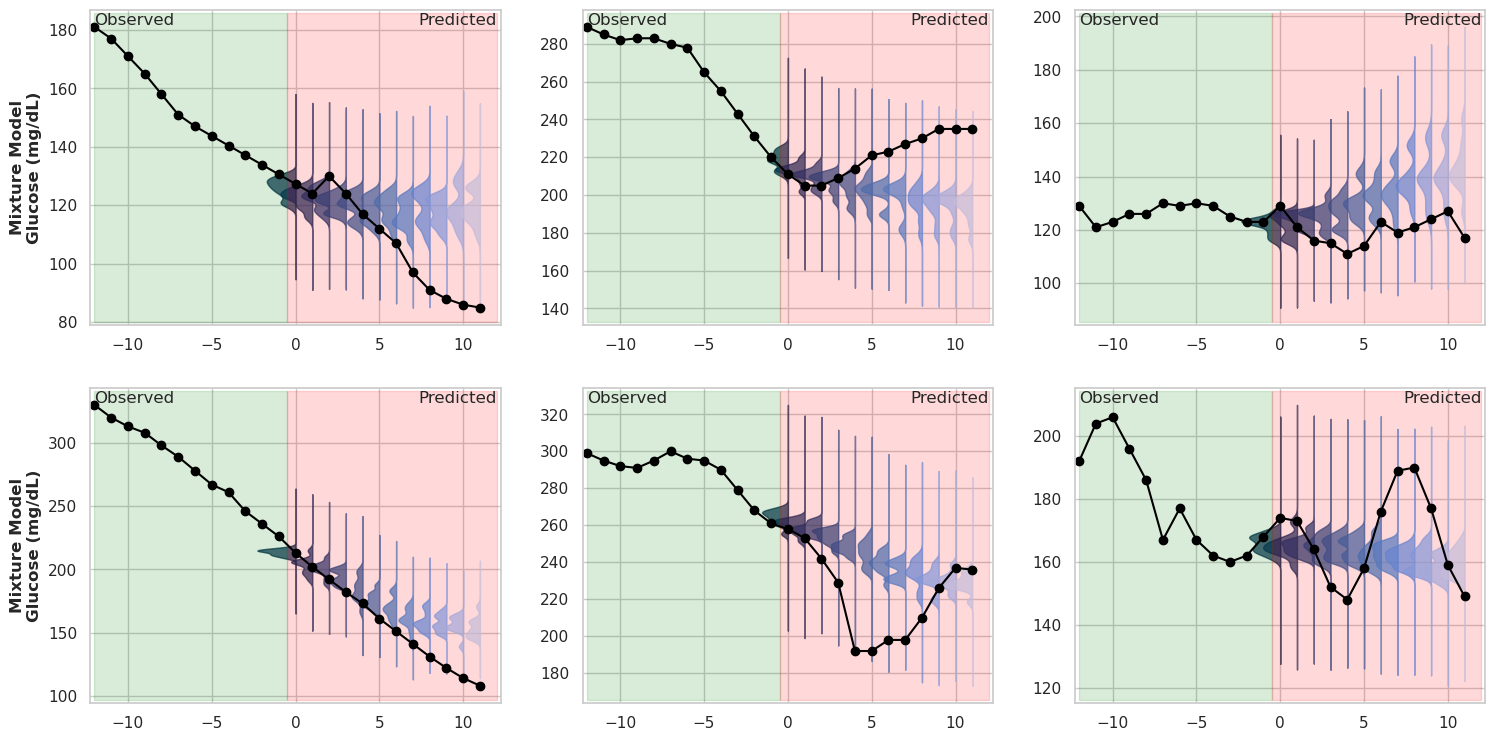

In [13]:
# load data
model_name = 'gluformer_weinstock'
inputs = save_inputs[model_name]
forecasts = save_forecasts[model_name]
trues = save_trues[model_name]

# convert trues to array
trues = np.array([trues[i].values() for i in range(len(trues))])

# generate samples from predictive distribution
samples = np.random.normal(loc=forecasts[..., None],
                            scale=1,
                            size=(forecasts.shape[0], 
                                    forecasts.shape[1], 
                                    forecasts.shape[2],
                                    30))
samples = samples.reshape(samples.shape[0], samples.shape[1], -1)

# plot
plot_samples = [100, 1100, 2500, 3000, 4000, 10000]
fig, axs = plt.subplots(2, 3, figsize=(18, 9))

for ind in range(6):
        ax = axs[ind // 3, ind % 3]
        # if plot number == 0 or 3, add y-label
        if ind % 3 == 0:
                ax.set_ylabel('Mixture Model\nGlucose (mg/dL)')
        # select sample to plot
        ind = plot_samples[ind]
        for point in range(samples.shape[1]):
                kde = stats.gaussian_kde(samples[ind, point, :])
                maxi, mini = 1.2 * np.max(samples[ind, point, :]), 0.8 * np.min(samples[ind, point, :])
                y_grid = np.linspace(mini, maxi, 200)
                x = kde(y_grid)
                ax.fill_betweenx(y_grid, x1 = point, x2 = point - x * 15, 
                                alpha=0.7, 
                                edgecolor='black',
                                color=cmap(point / samples.shape[1]))
        # plot true value
        ax.plot(np.arange(-12, 12), 
                np.concatenate([inputs[ind, -12:, 0], trues[ind, :, 0]]), 
                label='input', 
                color='black', 
                marker='o')
        # deliniate observed and predicted part
        abs_min, abs_max = ax.get_ylim()
        ax.fill_betweenx([abs_min, abs_max], x1 = -12, x2 = -0.5, color='green', alpha=0.15)
        ax.fill_betweenx([abs_min, abs_max], x1 = -0.5, x2 = 12, color='red', alpha=0.15)
        ax.text(.01, .99, 'Observed', ha='left', va='top', transform=ax.transAxes)
        ax.text(.99, .99, 'Predicted', ha='right', va='top', transform=ax.transAxes)
        ax.margins(0.01)
# save figure
plt.savefig('./paper_results/plots/gluformer_prediction.pdf', bbox_inches='tight')

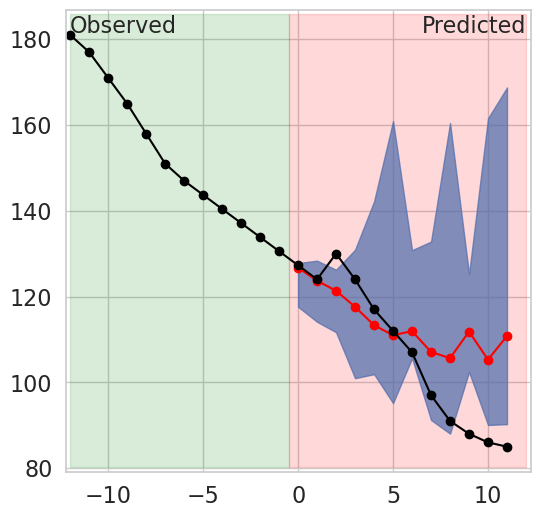

In [14]:
# load data
model_name = 'tft_weinstock'
inputs = save_inputs[model_name]
forecasts = save_forecasts[model_name]
trues = save_trues[model_name]

# convert to array
trues = np.array([trues[i].values() for i in range(len(trues))])
forecasts = np.array([forecasts[i].all_values() for i in range(len(forecasts))])

# plot
ind = 112
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
# plot predictions
lower_quantile = np.quantile(forecasts, 0.05, axis=-1)
upper_quantile = np.quantile(forecasts, 0.95, axis=-1)
median = np.quantile(forecasts, 0.5, axis=-1)
ax.fill_between(np.arange(12),
                lower_quantile[ind, :, 0],
                upper_quantile[ind, :, 0],
                alpha=0.7,
                edgecolor='black',
                color=cmap(0.5))
ax.plot(np.arange(12), median[ind, :, 0], color='red', marker='o')
# plot true value
ax.plot(np.arange(-12, 12), 
        np.concatenate([inputs[ind, -12:, 0], trues[ind, :, 0]]), 
        label='input', 
        color='black', 
        marker='o')
# deliniate observed and predicted part
abs_min, abs_max = ax.get_ylim()
ax.fill_betweenx([abs_min, abs_max], x1 = -12, x2 = -0.5, color='green', alpha=0.15)
ax.fill_betweenx([abs_min, abs_max], x1 = -0.5, x2 = 12, color='red', alpha=0.15)
ax.text(.01, .99, 'Observed', ha='left', va='top', transform=ax.transAxes, fontsize=16)
ax.text(.99, .99, 'Predicted', ha='right', va='top', transform=ax.transAxes, fontsize=16)
# change fontsize
for item in ([ax.xaxis.label, ax.yaxis.label] +
                ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(16)
if ax.get_legend() is not None:
        for item in ax.get_legend().get_texts():
                item.set_fontsize(12)
ax.margins(0.01)
# save figure
plt.savefig('./paper_results/plots/tft_single_prediction.pdf', bbox_inches='tight')

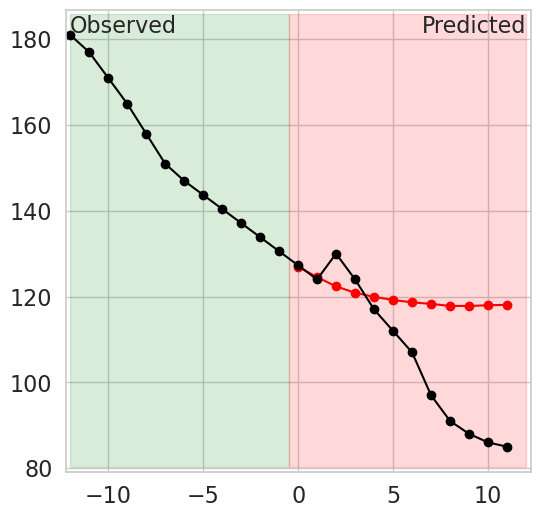

In [15]:
# load data
model_name = 'nhits_weinstock'
inputs = save_inputs[model_name]
forecasts = save_forecasts[model_name]
trues = save_trues[model_name]

# convert to array
trues = np.array([trues[i].values() for i in range(len(trues))])
forecasts = np.array([forecasts[i].all_values() for i in range(len(forecasts))])

# plot
ind = 148
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
# plot predictions
ax.plot(np.arange(12), forecasts[ind, :, 0, 0], color='red', marker='o')
# plot true value
ax.plot(np.arange(-12, 12), 
        np.concatenate([inputs[ind, -12:, 0], trues[ind, :, 0]]), 
        label='input', 
        color='black', 
        marker='o')
# deliniate observed and predicted part
abs_min, abs_max = ax.get_ylim()
ax.fill_betweenx([abs_min, abs_max], x1 = -12, x2 = -0.5, color='green', alpha=0.15)
ax.fill_betweenx([abs_min, abs_max], x1 = -0.5, x2 = 12, color='red', alpha=0.15)
ax.text(.01, .99, 'Observed', ha='left', va='top', transform=ax.transAxes, fontsize=16)
ax.text(.99, .99, 'Predicted', ha='right', va='top', transform=ax.transAxes, fontsize=16)
# change fontsize
for item in ([ax.xaxis.label, ax.yaxis.label] +
                ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(16)
if ax.get_legend() is not None:
        for item in ax.get_legend().get_texts():
                item.set_fontsize(12)
ax.margins(0.01)
# save figure
plt.savefig('./paper_results/plots/nhits_single_prediction.pdf', bbox_inches='tight')